# Tensor Flow Introduction
November 2016, KN

In [1]:
# Import modules
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

In [4]:
# Import more modules
%matplotlib inline
import numpy as np
import matplotlib.pylab as plt

## Intro
Going through simple tutorial first, just to go through https://www.tensorflow.org/versions/r0.11/tutorials/mnist/beginners/index.html

In [3]:
# Load up MNIST data
mnist = input_data.read_data_sets("/Users/kateniehaus/General_code/data/MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [ ]:
# Illustrate raw data
print('Dimensions of training set: {0}'.format(np.shape(mnist.train.images)))
exInd = 5
exImage = mnist.train.images[exInd,:].reshape(28,-1)  # 28x28 pixels in each image
plt.pcolormesh(exImage, cmap='Blues')

In [ ]:
# Set-up tensor flow variables
dimen = 28*28  # Size of images and therefore the imput vectors
numClasses = 10   # Number of possible digits (0-9)

# Placeholders
x = tf.placeholder(tf.float32, shape=[None, dimen])
# None means dimension can be of any length
# Doing this to create placeholder for each 28x28 pixel image
y_true = tf.placeholder(tf.float32, shape=[None, numClasses])
# one-hot vector indivating true digit class

# Variables
# (model parameters are usually tensorflow variables)
# Need to initialize values for variables
w = tf.Variable(tf.zeros([dimen,numClasses]))
b = tf.Variable(tf.zeros([numClasses]))

# Softmax
y = tf.nn.softmax(tf.matmul(x,w) + b)

# Cross-entropy
cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_true*tf.log(y), reduction_indices=[1]))
# tf.reduce_mean gets mean cross-entropy for all samples
# more numerically stable:
#cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(y, y_true))
# but then softmax already taken, so would remove from y function 

# Need to initialize variables and launch a session
# Session is connection to C++ code backend to do computation
# First, create graph and then launch in a session
init = tf.initialize_all_variables()
sess = tf.Session()
sess.run(init)

In [ ]:
# Optimize
learnRate = 0.5
train_step = tf.train.GradientDescentOptimizer(learnRate).minimize(cross_entropy)
# When this step is run, it will apply gradient descent updates to params

# Running training step
numSteps = 1000
batchSize = 100
for i in range(numSteps):
    batch_xs, batch_ys = mnist.train.next_batch(batchSize)
    sess.run(train_step, feed_dict={x: batch_xs, y_true: batch_ys})
    # feed_dict replaces placeholders with training examples
    # (can use feed_dict to replace any tensor in computation graph)

In [ ]:
# Look at performance in training data
predLabels = tf.argmax(y,1)
trueLabels = tf.argmax(y_true,1)

ifCorrect = tf.equal(predLabels, trueLabels)

accFunc = tf.reduce_mean(tf.cast(ifCorrect, tf.float32))

In [ ]:
# Look at performance in test data

testPerf_acc = sess.run(accFunc, feed_dict={x:mnist.test.images, y_true:mnist.test.labels})
print('Test accuracy: {0:.2f}%'.format(100*testPerf_acc))

## With interactive session

https://www.tensorflow.org/versions/r0.11/tutorials/mnist/pros/index.html

In [34]:
# Or, can use an interactive session
# With interactive session, can interleave graph-building and graph-running operations
sess2 = tf.InteractiveSession()

# (As above)
dimen = 28*28  # Size of images and therefore the imput vectors
numClasses = 10   # Number of possible digits (0-9)
# Placeholders
x = tf.placeholder(tf.float32, shape=[None, dimen])
y_ = tf.placeholder(tf.float32, shape=[None, numClasses])
# Variables
w = tf.Variable(tf.zeros([dimen,numClasses]))
b = tf.Variable(tf.zeros([numClasses]))
# Regression model
y = tf.matmul(x,w) + b
# Cross-entropy
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(y, y_))

sess2.run(tf.initialize_all_variables())

# Optimize
learnRate = 0.5
train_step = tf.train.GradientDescentOptimizer(learnRate).minimize(cross_entropy)

# Running training step
numSteps = 1000
batchSize = 100
for i in range(numSteps):
    batch = mnist.train.next_batch(batchSize)
    train_step.run(feed_dict={x: batch[0], y_: batch[1]})
    
# Look at performance
predLabels = tf.argmax(y,1)
trueLabels = tf.argmax(y_,1)

ifCorrect = tf.equal(predLabels, trueLabels)
accFunc = tf.reduce_mean(tf.cast(ifCorrect, tf.float32))

testPerf_acc = accFunc.eval(feed_dict={x: mnist.test.images, y_: mnist.test.labels})
print('Test accuracy: {0:.2f}%'.format(100*testPerf_acc))


Test accuracy: 91.48%


## Simple conv net

https://www.tensorflow.org/versions/r0.11/tutorials/mnist/pros/index.html

Remember: CNN is a bunch of convolution layers + ReLU applied
(where the filters [= conv layers = kernels = filters = feature detectors] are learned)

In [2]:
# Make some functions 


def sizeNextLayer(w,F=3,P=1,S=1):
    """ Returns dimension expected, given parameters for conv layer
    
    w: int
        Width of input
        
    F: int (default=3)
        Receptive field of neuron
        
    P: int (default=1)
        Number of 0s to add for padding of input
        
    S: int (default=1)
        Stride size
        
    """
    return (w-F+2*P)/np.float(S) + 1

def weight_variable(shape):
    """Want weight initializations to have noise for symmetry breaking"""
    initial = tf.truncated_normal(shape, stddev=0.1)
    # outputs draws from truncated normal w/ mean=0 (default std=1)
    # shape should be 1-D
    return tf.Variable(initial)

def bias_variable(shape):
    """Want positive bias for ReLU neurons to avoid dead neurons (i.e., never activate)"""
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

def conv2d(x,W, S=1):
    """Want to set S=1 stride and add zero padding to keep output of same size as input
    
    Zero padding: means that when applying convolution at edges, pad with zeros 
    to enable the computation (vs. narrow convolution)
    --> 'SAME' means set padding so output size=input size
    
    Stride size: amount to shift filter in each step
    
    x: 4D tensor
        Input data (batch, height, width, channels)
    
    W: weights of neuron
    
    """
    return tf.nn.conv2d(x,W, strides=[S,S,S,S], padding='SAME')

def max_pool_set(x, S=2, F=2):
    """Want to do max pooling over 2x2 blocks
    (means, take max value contained within each 2x2 block)
    
    x: 4D tensor
        Input data (batch, height, width, channels)
        
    S: int (default=2)
        Stride size
    
    F: int (default=2)
        Spatial extent
    
    Max pooling just operates spatially, so depth in terms of channels=1
    """
    return tf.nn.max_pool(x, ksize=[1,F,F,1], strides=[1,S,S,1], padding='SAME')

In [6]:
# Set variables
F = 1   # receptive field of neuron (i.e., patch size)
d0 = 1  # (number input color channels)
w0 = 28   # width of input (=height)
K1 = 32  # number of filters in layer 1
K2 = 64   # number of filters in layer 2
K3 = 1024    # number of filters in FC layer 3
# Padding, P, taken care of internally with TF
# We already set S defaults in shortcut functions above
S_m = 2  # max-pooling  
F_m = 2  # max-pooling
nC = 10    # number of classes in final labels

# To look at for interest & playing:
sizeNextLayer(w0,F=F,P=2,S=1)

#w0*w0

32.0

### Setting up architecture

In [66]:
# Create first convolutional layer (using shortcut functions above)
W_conv1 = weight_variable([F,F, d0, K1])
b_conv1 = bias_variable([K1])

x = tf.placeholder(tf.float32, shape=[None, w0*w0])
y_ = tf.placeholder(tf.float32, shape=[None, nC])

# reshape images into 4d tensor of: [numExamples, width, height, num color channels]
x_image = tf.reshape(x, [-1, w0, w0,d0])

# convolve image with weight tensor and add bias
conv1 = conv2d(x_image, W_conv1) + b_conv1
# apply ReLU function
h_conv1 = tf.nn.relu(conv1)
# max pool
h_pool1 = max_pool_set(h_conv1, S=S_m, F=F_m)

# --> so after max-pooling over 2x2 blocks, 'image' size is 14x14

In [67]:
# Create second convolutional layer

W_conv2 = weight_variable([F,F, K1, K2])
b_conv2 = bias_variable([K2])

h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_set(h_conv2, S=S_m, F=F_m)

# --> so after max-pooling over 2x2 blocks, 'image' size is 7x7

In [68]:
# Create FC layer
numMaxPools = 2
currImSize = w0/(F_m*numMaxPools)

W_fc1 = weight_variable([currImSize*currImSize*K2, K3])
b_fc1 = bias_variable([K3])

h_pool2_flat = tf.reshape(h_pool2, [-1, currImSize*currImSize*K2])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)


In [69]:
# Add dropout layer
# Note: no scaling needed b/c handled behind the scenes by TF

keep_prob = tf.placeholder(tf.float32)   # make placeholder so can turn off during testing
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)  


In [70]:
# Add readout layer

W_fc2 = weight_variable([K3, nC])
b_fc2 = bias_variable([nC])

y_conv = tf.matmul(h_fc1_drop, W_fc2) + b_fc2   #(same form as regression model above)
# (for easy comparison, it was: y = tf.matmul(x,w) + b)

### Training

In [71]:
trainRate = 1e-4


# Loss
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(y_conv, y_))
# (same form as regression above; for easy comparison, it was: 
# cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(y, y_)))

# use ADAM optimizer (stochastic optimizer)
train_step = tf.train.AdamOptimizer(trainRate).minimize(cross_entropy)

# Look at performance
predLabels = tf.argmax(y_conv,1)
trueLabels = tf.argmax(y_,1)

ifCorrect = tf.equal(predLabels, trueLabels)
accFunc = tf.reduce_mean(tf.cast(ifCorrect, tf.float32))

In [74]:
# initialize
sess3 = tf.InteractiveSession()
sess3.run(tf.initialize_all_variables())

# Running training step
numSteps = 20000
batchSize = 50
for i in range(numSteps):
    batch = mnist.train.next_batch(batchSize)
    #batch_x = tf.reshape(batch[0], [-1,28,28,1])
    if i%100==0:
        train_acc = accFunc.eval(feed_dict={x: batch[0], y_: batch[1], keep_prob:1.0})
        print('Step {0}, training acc = {1:.3f}'.format(i, train_acc))
    train_step.run(feed_dict={x: batch[0], y_: batch[1], keep_prob:0.5})
    
    

testPerf_acc = accFunc.eval(feed_dict={x: mnist.test.images, y_: mnist.test.labels, keep_prob:1.0})
print('Test accuracy: {0:.2f}%'.format(100*testPerf_acc))

Step 0, training acc = 0.060
Step 100, training acc = 0.860
Step 200, training acc = 0.860
Step 300, training acc = 0.920
Step 400, training acc = 0.900
Step 500, training acc = 0.960
Step 600, training acc = 0.920
Step 700, training acc = 0.980
Step 800, training acc = 0.960
Step 900, training acc = 0.920
Step 1000, training acc = 0.980
Step 1100, training acc = 0.980
Step 1200, training acc = 0.940
Step 1300, training acc = 0.960
Step 1400, training acc = 0.960
Step 1500, training acc = 0.960
Step 1600, training acc = 0.940
Step 1700, training acc = 0.960
Step 1800, training acc = 0.940
Step 1900, training acc = 0.980
Step 2000, training acc = 0.980
Step 2100, training acc = 0.960
Step 2200, training acc = 0.940
Step 2300, training acc = 1.000
Step 2400, training acc = 0.940
Step 2500, training acc = 1.000
Step 2600, training acc = 0.960
Step 2700, training acc = 1.000
Step 2800, training acc = 0.980
Step 2900, training acc = 1.000
Step 3000, training acc = 0.960
Step 3100, training 

# Showing some workings

Basic idea from: http://cs231n.github.io/convolutional-networks/

Writing out some of the math explicitly; 
Showing how can reshape 3D tensors into 2D matrices and perform dot products between filter and input to produce same result (i.e., filtering is essentially a dot product between input and learned weight matrix)

In [44]:
# Functions to help

def convertImage2ColVec(x, F, P, S):
    """
    Converts 3D image into form in which dot products can 
    be calculated
    (to illustrate approach from CS231n)
    
    NOTE: image already zero-padded at this point
    
    x: tensor (w0, h0, d0)
        Input image
    
    F: int
        receptive field
        
    P: int
        Amount of zero padding to use around image
        
    S: int
        Stride size
    
    """
    w0p,h0p,d0 = np.shape(x)  # already padded
    w0 = w0p-2*P
    w1 = int(sizeNextLayer(w0,F,P,S))
    numR_new = F*F*d0
    numC_new = w1*w1
    x_col = np.zeros((numR_new, numC_new))  # new matrix to hold output
    i2=0
    for old_i in range(0,w1,S):
        for old_j in range(0,w1,S):
            newSlice = x[old_i:old_i+F,old_j:old_j+F,:]
            x_col[:,i2] = np.ravel(newSlice.reshape(numR_new,-1))
            i2+=1
    return x_col
    

(9, 784)

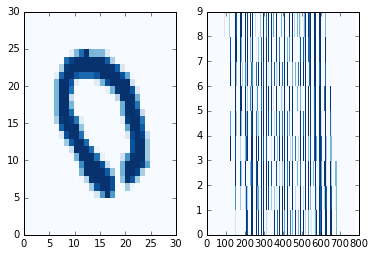

In [58]:
exInd = 7  # indice to choose from mnist
w0 = 28   # original width of image in pixels
P=1   # amount of padding
F = 3  # receptive field of neuron
S = 1   # stride
d0 = 1    # original depth of image (i.e., number of channels)

# get example image
exImage = mnist.train.images[exInd,:].reshape(w0,-1)  # 28x28 pixels in each image
exImage_3D = mnist.train.images[exInd,:].reshape(w0,-1, 1)  # 28x28 pixels in each image

# pad image with zeros 
exImage_padded = np.pad(exImage,P,'constant', constant_values=0)
plt.subplot(1,2,1)
plt.pcolormesh(exImage_padded, cmap='Blues')
np.shape(exImage_padded)
# reshape to 3D
exImage_padded_3D = exImage_padded.reshape(w0+2*P,-1,1)
np.shape(exImage_padded_3D)

w2 = sizeNextLayer(w0,F,P,S)  # get size of next layer

# convert to 2D matrix, using function above
exImage_cols = convertImage2ColVec(exImage_padded_3D, F=F, P=P, S=S)
plt.subplot(1,2,2)
plt.pcolormesh(exImage_cols, cmap='Blues')

np.shape(exImage_cols)




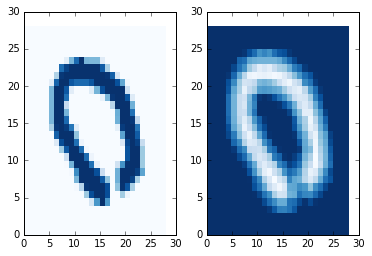

In [77]:
# Illustrate effect of applying filter/conv layer

# Set some weights
# say single filter
Wr_set = np.array([[-1,0,-1],[0,0,0],[-1,0,-1]])
K = 1   # number of filters

# perform dot product on 2D matrices
Wr = np.reshape(Wr_set, (K, F*F*d0) ) # size K x (F*F*d0)
Xc = exImage_cols  # size (F*F*d0) x (sizeNextLayer**2)
dot_out = np.dot(Wr, Xc)

np.shape(dot_out)

# reshape back into 3D
out_layer = np.reshape(dot_out,(w2, w2, K))

# Plot (showing only a single channel)
plt.subplot(1,2,1)
plt.pcolormesh(exImage, cmap='Blues')
plt.subplot(1,2,2)
plt.pcolormesh(out_layer[:,:,0], cmap='Blues')

## Quick aside: how to print!?

In [94]:
sess4 = tf.InteractiveSession()

In [102]:
a = np.array([[1,2,3], [4,3,5]])
b = np.array([[5,3,2], [7,5,6]])

c = np.dot(a,b.T)
print(c)

[[17 35]
 [39 73]]


In [100]:
a = tf.constant([1,2,3,4,3,5], shape=[2,3])
b = tf.constant([5,3,2,7,5,6], shape = [2,3])
c = tf.matmul(a, b, transpose_b=True)
c = tf.Print(c, [c], message="Printing c")
# Have to evaluate and be in a session in order to see output
c.eval()

array([[17, 35],
       [39, 73]], dtype=int32)